# Flats Weighting
J. C. Runnoe, 2021

This Jupyter notebook focuses on calculating a weighted mean flat from the V-band flats using methods not available through CCDPROC.

In [31]:
# import block
import numpy as np
from astropy.io import fits
%matplotlib inline
from matplotlib import pyplot as plt
from astropy.visualization import hist
from astropy.stats import sigma_clip
import ccdproc as ccdp
from matplotlib import rc
from datetime import datetime
from astropy.nddata import CCDData
import os

if os.getcwd()[7:16]=='runnojc1':
    phot_tutorial_dir = '/Users/runnojc1/Dropbox/Research/teaching/F2021/ASTR8060/work/reductions/example/notebooks'
else:
    phot_tutorial_dir = '/Users/runnoejc/Dropbox/Research/teaching/F2021/ASTR8060/work/reductions/example/notebooks'

import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

In [32]:
# plotting defaults
# Use custom style for larger fonts and figures
plt.style.use(phot_tutorial_dir+'/guide.mplstyle')

# Set some default parameters for the plots below
rc('font', size=12)
rc('axes', grid=True)

In [33]:
# define directories
data_dir = '/Users/runnojc1/Dropbox/Research/teaching/F2021/ASTR8060/Imaging/'            # raw data directory
reduced_dir = '/Users/runnojc1/Dropbox/Research/teaching/F2021/ASTR8060/Imaging_reduced/' # working directory
reduced_dir = '/Users/runnoejc/Dropbox/Research/teaching/S2021/ASTR8060/work/reductions/reduced/'

In [34]:
# define the trimsec for python (i.e. not for the fits header)
# this assumes that you have not yet trimmed the flats
r0 = 0
r1 = 2048
c0 = 54
c1 = 2101

## 1. What methods are at your disposal for imaging combination?

Write down the general techniques that you can apply to combine images.

1. <br>
2. <br>
3. <br>
4. <br>

## 2. What is the best method for combining the flats?

Our ultimate goal is to explore different methods for combining flats and settle on the best one for this data set. We will use the V-band flats as an example and assume that whatever method works best for them will work well in the other bands (this is very definitely an assumption). 

To answer this question, you will need to draw on what you learned from the flats.ipynb notebook, plus lessons in this notebook. Come back here and update the text below as you learn more about each method.

Remember, to determine whether one method is better than another use difference/ratio images to look for 2D patterns and use np.std() to calculate the RMS of pixel values in an individual frame (lower is better).

Write some notes about how the following methods play out in the V-band data:

 - <b>Mean combine</b>
 - <b>Median combine</b>
 - <b>Mean w/ sigma clipping</b>
 - <b>Median w/ sigma clipping</b>  
 - <b>Mean w/ sigma clipping and scaling</b>
 - <b>Median w/ sigma clipping and scaling</b>
 - <b>Mean w/ scaling, sigma clipping, and weighting </b>

## 3. Weighting your flats

Weighting is a method of deciding how important a frame is in the image combination step. One reason you might want to do this is that you may decide that the frames with higher counts should have more weight, since in principle they have higher fidelity than flats with very few counts. In this case, you would use some measure of the average counts in the frame to weight it.

It may seem like scaling and weighting are almost the inverse of each other. The key is that they must happen in the proper order. The sigma clipping needs to be done on scaled images, so only spurious pixels are rejected. Then, the weights for the weighted mean must be adjusted for pixels that were thrown out. Additionally, different functions or values may be used for scaling and weighting, so it makes sense to separate them.

Let's go through this process and clarify the steps.

<b> Read in your V-band flats </b><br>
Ideally already bias subtracted and trimmed, but raw will work.

In [35]:
# read in the flats, use the clipped ones if you can


<b> Scale the flats to have an average value near 1. </b><br>
To do this, make an array of scale factors that are the mean (or median) for each image. Then divide each frame by its scale factor.

In [90]:
# get the scale factor
# this calculates an array of scales (one for each frame)
# and makes 2048x2048 images of the scale factor that can be easily multiplied by a frame
scale  = 1.    # fill this in, you want an array with the mean for each frame
scales = np.ones_like(flats)*scale[:,np.newaxis,np.newaxis] 

In [91]:
# scale the flats


<b>Calculate a weighted mean flat</b><br>

A weighted mean is calculated as follows:<br>

$W = \frac{\sum_i{w_{i}\cdot x_{i}}}{\sum_i{w_{i}}}$.

Note that the weighted median would correspond to the 50\% weighted percentile, but there is not a standardized algorithm for calculating weighted percentiles. Thus, at this point we will resort to mean combine with sigma clipping to get rid of outliers.

In [125]:
# weighted mean  
flat_wt  = np.sum(scales*flats,axis=0)/np.sum(scale)                # this and next line are eq.
flat_wt2 = np.average(flats,axis=0,weights=scales/np.sum(scale))    # to 1d-12 (numerical noise)

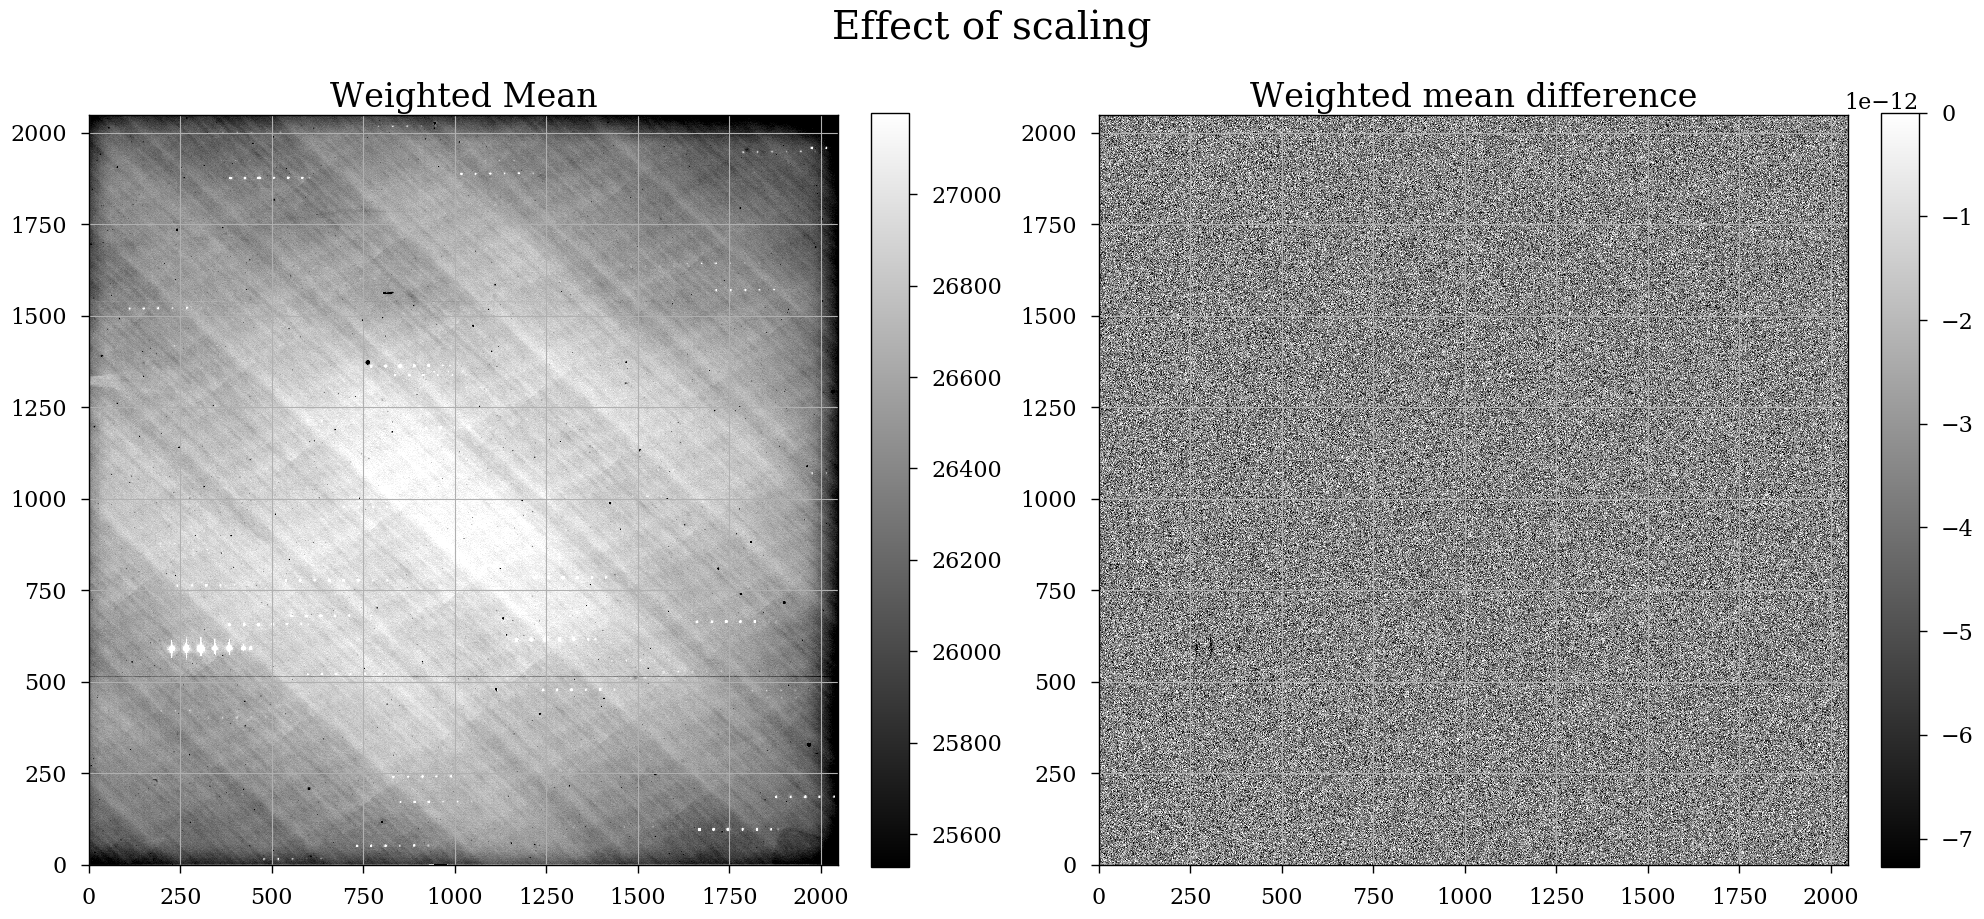

In [124]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title('Weighted Mean')
show_image(flat_wt, cmap='gray', ax=ax[0], fig=fig)
ax[1].set_title('Weighted mean difference')
show_image(flat_wt-flat_wt2, cmap='gray', ax=ax[1], fig=fig)
fig.suptitle('Effect of scaling',size=28)
plt.tight_layout()
plt.show()

<b>Calculate a scaled, sigma clipped, weighted mean flat</b><br>
First, sigma clip your scaled flats. Astropy has a sigma_clip() function, or you can write your own. It may be useful to use masked arrays for this step. Masked arrays are a Python construct that store a mask of True/False values with your data array. If you choose to mask a pixel (for example, because it was clipped) the mask value gets set to True for clipped pixels. Numpy has tools to interact with masked arrays, for example np.ma.average() and np.ma.sum(), which will ignore masked values in the average or sum. 

Then, calculate an array of weights using either the mean or median for each frame but ignoring the clipped pixels (i.e., they should not contribute to the mean or median).

Finally, calculate a weighted mean from the scaled, clipped flats.

Compare this to what you get if you do not weight the frames.

In [126]:
clipped   = sigma_clip(scaled_flats, sigma=2, axis=0,masked=True)
w         = np.array([np.ma.mean(i) for i in clipped*scales])
flat_scw  = np.ma.average(clipped,axis=0,weights=np.array(w))
flat_sc   = np.ma.average(clipped,axis=0)

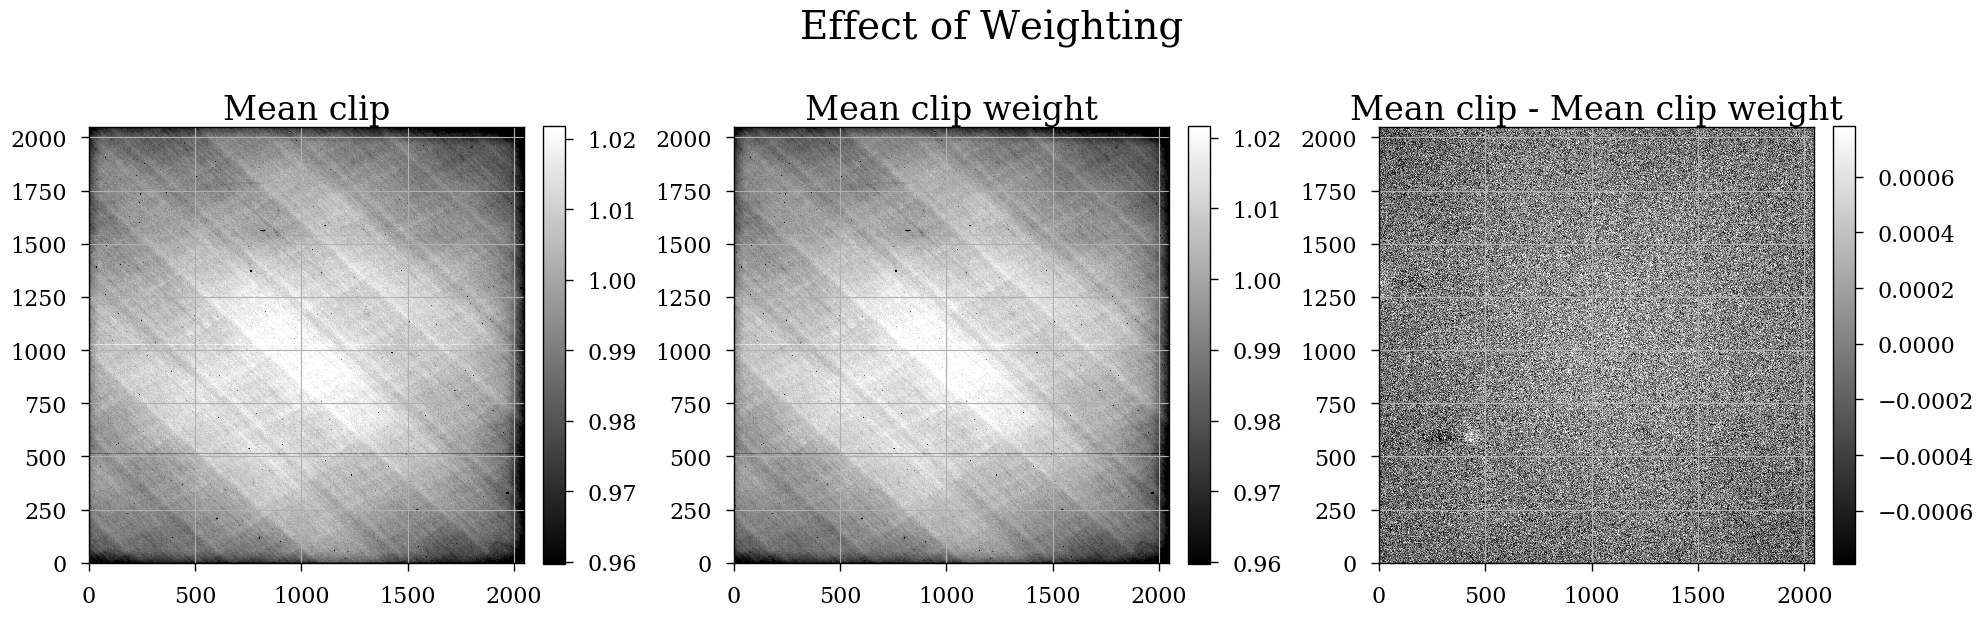

In [127]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax[0].set_title('Mean clip')
show_image(flat_sc, cmap='gray', ax=ax[0], fig=fig)
ax[1].set_title('Mean clip weight')
show_image(flat_scw, cmap='gray', ax=ax[1], fig=fig)
ax[2].set_title('Mean clip - Mean clip weight')
show_image(flat_sc-flat_scw, cmap='gray', ax=ax[2], fig=fig)
fig.suptitle('Effect of Weighting',size=28)
plt.tight_layout()
plt.show()

## 4. Sigma clipping

You could write your own code to do sigma clipping. In that case, the code below might be useful.

In [128]:
thresh     = 2. 
baseline   = np.median(scaled_flats,axis=0)
sigmas     = np.std(scaled_flats,axis=0)

scaled_flats_ma = scaled_flats
clip            = np.where((scaled_flats-baseline < -thresh*sigmas) | (scaled_flats-baseline > thresh*sigmas))
scaled_flats_ma[clip]    = np.nan
scales[clip]    = np.nan

## 5. Gratuitous steps

Look at CCDPROC and see how it handles weights. What is not ideal about this method?